## Customer segmentation

You are the owner of a shop. It doesn't matter if you own an e-commerce or a  supermarket. It doesn't matter if it is a small shop or a huge company such as Amazon or Netflix, it's better to know your customers.

You were able to collect basic data about your customers holding a membership card such as Customer ID, age, gender, annual income, and spending score. This last one is a score based on customer behavior and purchasing data.
There are some new products on the market that you are interested in selling. But you want to target a specific type of clients for each one of the products. Machine learning come in handy for this task. Clustering, a type of unsupervised algorithm, is able to create categories grouping similar individuals. So, you will find patterns among your customers. 

### Import modules requiered

First of all, we need to import the required module. 

In [75]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

For this particular project, we'll work with two `scikit-learn` modules: `Kmeans` and `PCA`. They will allow us to perform a clustering algorithm and dimensionality reduction.

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
import seaborn as sns
%matplotlib inline

In [6]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

### Read data into a DataFrame

We read the basic data stored in the [customers.csv](https://www.kaggle.com/akram24/mall-customers) file into a `DataFrame` using pandas. 

In [7]:
customers = pd.read_csv("customers.csv")

We check the first five rows of the DataFrame. We can see that we have: CustumerID, Gender, Age, Annual Income expressed as price x1000, and the spending score as we expected.

In [8]:
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Exploring the data

Now, it's time to explore the data to check the quality of the data and the distribution of the variables.

First, we check that if there is any missing value in the dataset. K-means algorithm is not able to deal with missing values. 

In [9]:
print(f"Missing values in each variable: \n{customers.isnull().sum()}")

Missing values in each variable: 
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Fortunately, there is no missing data. We can also check if there are duplicated rows.

In [10]:
print(f"Duplicated rows: {customers.duplicated().sum()}")

Duplicated rows: 0


Finally, we check how each variable is presented in the DataFrame. Categorical variables cannot be handled directly. K-means is based on distances. The approach for converting those variables depend on the type of categorical variables. 

In [117]:
print(f"Variable:                  Type: \n{customers.dtypes}") 

Variable:                  Type: 
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


After that, we can start observing the distribution of the variables. Here, we'll define two functions. The first one will retrieve descriptive statistics of the variables. The second one will help us graph the variable distribution.

For the descriptive statistcs, we'll get mean, standard deviation, median and variance. If the variable is not numeric, we'll get the counts in each category.

In [252]:
def statistics(variable):
    if variable.dtype == "int64" or variable.dtype == "float64":
        return pd.DataFrame([[variable.name, np.mean(variable), np.std(variable), np.median(variable), np.var(variable)]], 
                            columns = ["Variable", "Mean", "Standard Deviation", "Median", "Variance"]).set_index("Variable")
    else:
        return pd.DataFrame(variable.value_counts())

In [185]:
def graph_histo(x):
    if x.dtype == "int64" or x.dtype == "float64":
        # Select size of bins by getting maximum and minimum and divide the substraction by 10
        size_bins = 10
        # Get the title by getting the name of the column
        title = x.name
        #Assign random colors to each graph
        color_kde = list(map(float, np.random.rand(3,)))
        color_bar = list(map(float, np.random.rand(3,)))
        # Initialize figure
        plt.figure(figsize=(6,5))
        # Plot the displot
        sns.distplot(x, bins=size_bins, kde_kws={"lw": 1.5, "alpha":0.8, "color":color_kde},
                       hist_kws={"linewidth": 1.5, "edgecolor": "grey",
                                "alpha": 0.4, "color":color_bar})
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.ylabel("Frequency", size=16, labelpad=15);
        # Customize title
        plt.title(title, size=18)
        # Customize grid and axes visibility
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);
        plt.show()    
    else:
        pass 

We'll start by the **Spending Score**.

In [160]:
spending = customers["Spending Score (1-100)"]

In [205]:
statistics(spending)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
Spending Score (1-100),50.2,25.758882,50.0,663.52


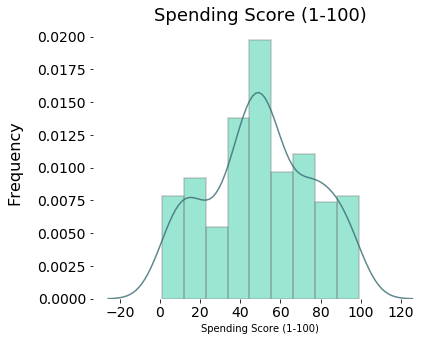

In [163]:
graph_histo(spending)

Then, we'll check **Age**.

In [157]:
age = customers["Age"]

In [206]:
statistics(age)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
Age,38.85,13.934041,36.0,194.1575


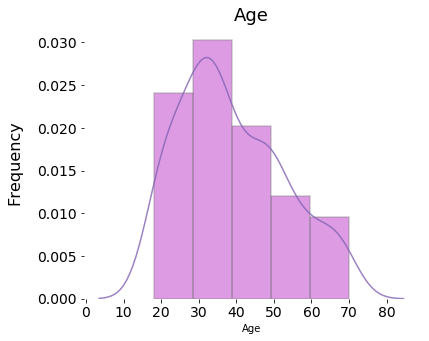

In [165]:
graph_histo(age)

Finally, we'll explore **Annual Income** variable.

In [166]:
income = customers["Annual Income (k$)"]

In [207]:
statistics(income)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
Annual Income (k$),60.56,26.198977,61.5,686.3864


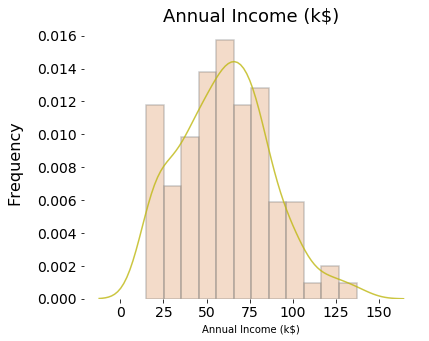

In [173]:
graph_histo(income)

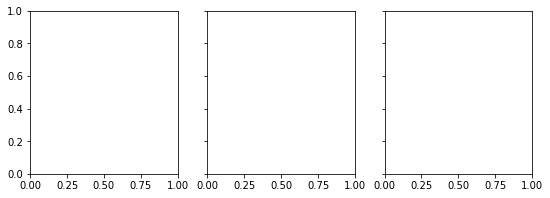

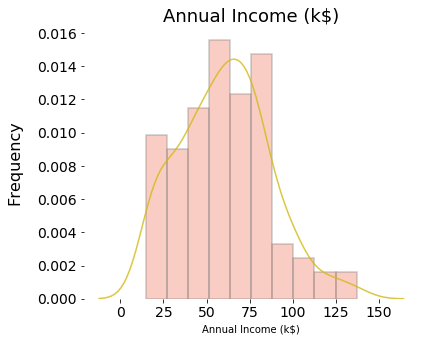

NameError: name 'names' is not defined

In [268]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0] = graph_histo(income)
axs[1].scatter(names, values)
axs[2].plot(names, values)

What should we look for? In order to apply K-means, we need to meet the algorithm assumptions. 
  
K-means assumes:

- Variance of distribution is spherical
- All variables has the same variance
- All clusters has the same number of observations.

In [9]:
X = customers.iloc[:, 1:]

In [15]:
X.Gender = X.Gender.apply(lambda x: 0 if x == "Male" else 1)

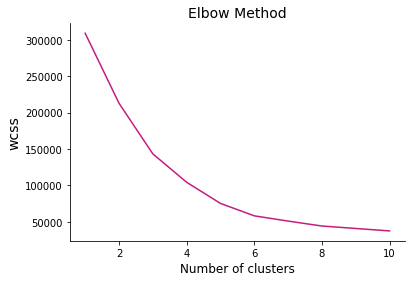

In [16]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

In [17]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

y_means = kmeans.fit_predict(X)

In [18]:
pca = PCA(n_components=2).fit(X)

In [19]:
pca_2d = pca.transform(X)

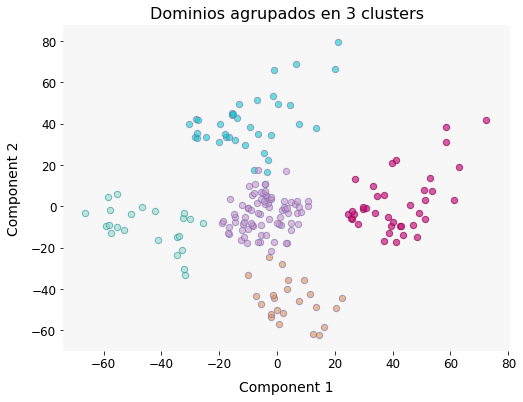

In [20]:
fig, ax = plt.subplots(figsize = (8, 6))

for i in range(0, pca_2d.shape[0]):
    if y_means[i] == 0:
        c1 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#99d8c9", s=40, edgecolors="#1c9099", alpha=0.6)
    elif y_means[i] == 1:
        c2 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#c51b8a", s=40, edgecolors="#980043", alpha=0.7)
    elif y_means[i] == 2:
        c3 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#c994c7", s=40, edgecolors="#756bb1", alpha=0.6)
    elif y_means[i] == 3:    
        c4 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#0bd0cb", s=40, edgecolors="#756bb1", alpha=0.6)
    elif y_means[i] == 4:
        c5 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#e0904e", s=40, edgecolors="#756bb1", alpha=0.6)
        
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('Dominios agrupados en 3 clusters', size=16)

ax.set_facecolor("#f7f7f7")

plt.show()

In [23]:
X2 = customers.iloc[:, 2:]

In [24]:
x = []
y = []
z = []
for i in range(0, pca_2d.shape[0]):
    x.append(pca_2d[i,0])
    y.append(pca_2d[i,1])
    z.append(i)

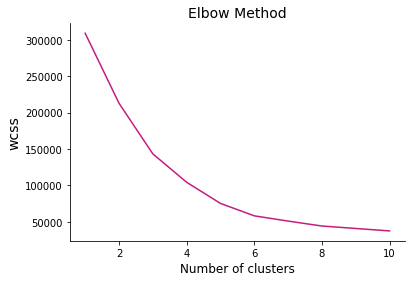

In [25]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

In [35]:
kmeans2 = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

y_means2 = kmeans2.fit_predict(X2)

In [36]:
pca2 = PCA(n_components=2).fit(X2)

In [37]:
pca_2d2 = pca2.transform(X)

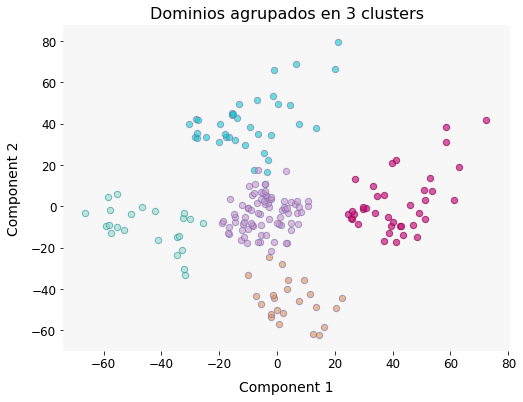

In [39]:
fig, ax = plt.subplots(figsize = (8, 6))

for i in range(0, pca_2d.shape[0]):
    if y_means2[i] == 0:
        c1 = plt.scatter(pca_2d2[i,0], pca_2d2[i,1], c="#99d8c9", s=40, edgecolors="#1c9099", alpha=0.6)
    elif y_means2[i] == 1:
        c2 = plt.scatter(pca_2d2[i,0], pca_2d2[i,1], c="#c51b8a", s=40, edgecolors="#980043", alpha=0.7)
    elif y_means2[i] == 2:
        c3 = plt.scatter(pca_2d2[i,0], pca_2d2[i,1], c="#c994c7", s=40, edgecolors="#756bb1", alpha=0.6)
    elif y_means2[i] == 3:    
        c4 = plt.scatter(pca_2d2[i,0], pca_2d2[i,1], c="#0bd0cb", s=40, edgecolors="#756bb1", alpha=0.6)
    elif y_means2[i] == 4:
        c5 = plt.scatter(pca_2d2[i,0], pca_2d2[i,1], c="#e0904e", s=40, edgecolors="#756bb1", alpha=0.6)
        
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('Dominios agrupados en 3 clusters', size=16)

ax.set_facecolor("#f7f7f7")

plt.show()

In [51]:
X4 = customers.iloc[:, 3:]

In [52]:
kmeans4 = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

y_means4 = kmeans2.fit_predict(X4)

In [55]:
sns.scatterplot()

TypeError: object of type 'NoneType' has no len()

In [76]:
labels = [customers["CustomerID"][i] for i in range(customers.shape[0])]

In [47]:
N = len(x)
colors = np.random.rand(N)*20
sz = np.random.rand(N)*30
#colors = [abs(j)*20 for j in x]
#sz = np.random.rand(N)*30


init_notebook_mode(connected=True)



data = [
    go.Scatter(
        x=x,
        y=y,
        mode='markers',
        text=labels,
        marker={'size': sz,
                'color': colors,
                'opacity': 0.6,
                'colorscale': 'Viridis'
                       })
        ]

layout = go.Layout(
    title='Desliza por encima de un punto para ver el dominio'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='my_plot')

NameError: name 'labels' is not defined

In [ ]:
plotly.offline.plot(fig, filename='name.html') 